## Dcard Machine Learning Homework
- Implementation by Mao-Siang Chen

### Import Modules

In [222]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.preprocessing import StandardScaler

### Set Random Seed

In [223]:
np.random.seed(42)

### Load Data

In [224]:
# Load data
train = pd.read_csv("ML Intern Homework/intern_homework_train_dataset.csv")
valid = pd.read_csv("ML Intern Homework/intern_homework_public_test_dataset.csv")

# Add new features
rnn_train = pd.read_csv("ML Intern Homework/train_rnn.csv")
rnn_valid = pd.read_csv("ML Intern Homework/valid_rnn.csv")

# RNN hidden layer output (shape: (6, 1))
train = pd.concat([train, rnn_train], axis=1)
valid = pd.concat([valid, rnn_valid], axis=1)

# Feature indicates like count increasing
train["increasing"] = train["like_count_6h"] - train["like_count_1h"]
valid["increasing"] = valid["like_count_6h"] - valid["like_count_1h"]


### Feature Engineering

In [225]:
# Log transform
train["like_count_1h"] = np.log1p(train["like_count_1h"])
train["like_count_2h"] = np.log1p(train["like_count_2h"])
train["like_count_3h"] = np.log1p(train["like_count_3h"])
train["like_count_4h"] = np.log1p(train["like_count_4h"])
train["like_count_5h"] = np.log1p(train["like_count_5h"])
train["like_count_6h"] = np.log1p(train["like_count_6h"])
train["like_count_24h"] = np.log1p(train["like_count_24h"])
train["increasing"] = np.log1p(train["increasing"])


valid["like_count_3h"] = np.log1p(valid["like_count_3h"])
valid["like_count_4h"] = np.log1p(valid["like_count_4h"])
valid["like_count_5h"] = np.log1p(valid["like_count_5h"])
valid["like_count_6h"] = np.log1p(valid["like_count_6h"])
valid["like_count_24h"] = np.log1p(valid["like_count_24h"])
valid["increasing"] = np.log1p(valid["increasing"])


# Remove outliers
train.drop(
    train[train["like_count_24h"] - train["like_count_6h"] > 3].index, inplace=True
)

# Change data type
x_train = train.loc[
    :,
    [
        "like_count_2h",
        "like_count_3h",
        "like_count_4h",
        "like_count_5h",
        "like_count_6h",
        "increasing",
        "0",
        "1",
        "2",
        "3",
        "4",
        "5",
    ],
].to_numpy()

y_train = train["like_count_24h"].to_numpy()

x_valid = valid.loc[
    :,
    [
        "like_count_2h",
        "like_count_3h",
        "like_count_4h",
        "like_count_5h",
        "like_count_6h",
        "increasing",
        "0",
        "1",
        "2",
        "3",
        "4",
        "5",
    ],
].to_numpy()
y_valid = valid["like_count_24h"].to_numpy()


# Scale data
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_valid = scaler.transform(x_valid)

print(x_train.shape)
print(x_valid.shape)

(49201, 12)
(10000, 12)


## Easy Data Analysis

### Show Correlation

/var/folders/nc/zmjfff853y33j17lwwdk299w0000gn/T/ipykernel_90391/1524494364.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(train.corr())


<Axes: >

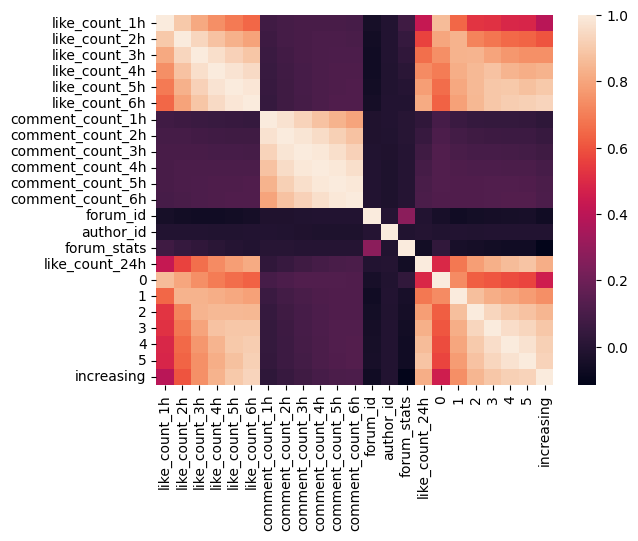

In [226]:
sns.heatmap(train.corr())

### Show distribution of like counts

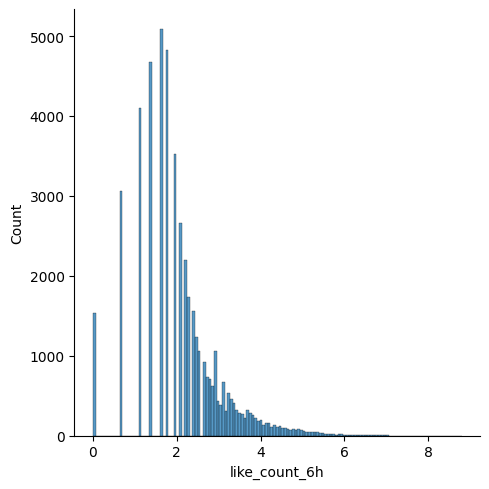

In [227]:
sns.displot(train["like_count_6h"])

### Show Scatterplot

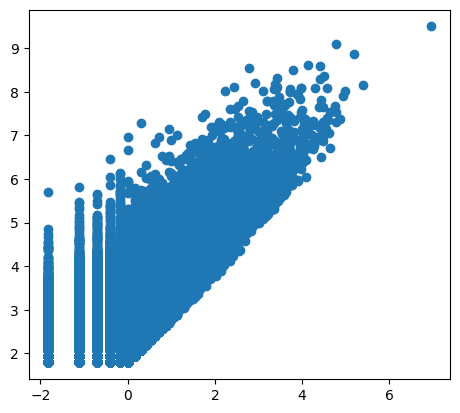

In [228]:
plt.scatter(x_train[:, 2],y_train)
plt.gca().set_aspect(1)

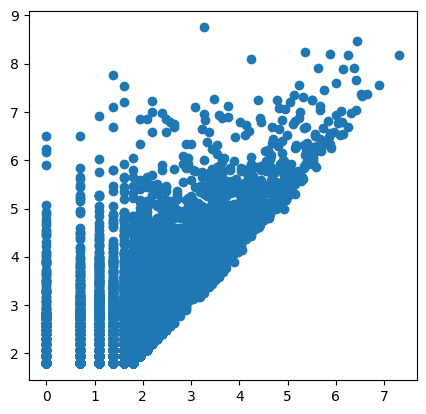

In [229]:
plt.scatter(valid["like_count_6h"], valid["like_count_24h"])
plt.gca().set_aspect(1)


In [230]:
# Skewness and Kurtosis
print("Skewness: %f" % train["like_count_6h"].skew())
print("Kurtosis: %f" % train["like_count_6h"].kurt())

Skewness: 0.791454
Kurtosis: 1.472321


### Models

In [231]:
xgboost = XGBRegressor(
    n_estimators=300,
    learning_rate=0.01,
    max_depth=5,
    subsample=0.7,
)

xgboost.fit(x_train, y_train)
y_pred = xgboost.predict(x_valid)
mape = mean_absolute_percentage_error(y_valid, y_pred)

print(f"MAPE: {mape}")
# 0.13101 with 300 estimators and 0.01 learning rate and 5 max depth and 0.7 subsample

MAPE: 0.1310108303108615


### Hyperparameter Tuning

In [232]:
# from sklearn.model_selection import GridSearchCV

# param = {
#     "n_estimators": [300, 350, 400],
#     "learning_rate": [0.005, 0.01, 0.02],
#     "max_depth": [3, 5],
#     "subsample": [0.7, 0.75, 0.8],
# }

# xgb_norm = XGBRegressor()

# grid = GridSearchCV(xgb_norm, param, scoring="neg_mean_absolute_percentage_error", cv=5)
# grid.fit(x_train, y_train)

# print(grid.best_params_)

In [233]:
# from sklearn.ensemble import GradientBoostingRegressor

# gbr = GradientBoostingRegressor(
#     n_estimators=400,
#     learning_rate=0.02,
#     max_depth=5,
#     subsample=0.8
# )
# gbr.fit(x_train, y_train)

# y_pred = gbr.predict(x_valid)
# mape = mean_absolute_percentage_error(y_valid, y_pred)

# print(f"MAPE: {mape}")

### Inference

In [234]:
test = pd.read_csv("ML Intern Homework/intern_homework_private_test_dataset.csv")

test["increasing"] = test["like_count_6h"] - test["like_count_1h"]

test["like_count_2h"] = np.log1p(test["like_count_2h"])
test["like_count_3h"] = np.log1p(test["like_count_3h"])
test["like_count_4h"] = np.log1p(test["like_count_4h"])
test["like_count_5h"] = np.log1p(test["like_count_5h"])
test["like_count_6h"] = np.log1p(test["like_count_6h"])
test["increasing"] = np.log1p(test["increasing"])

rnn_test = pd.read_csv("ML Intern Homework/test_rnn.csv")
test = pd.concat([test, rnn_test], axis=1)


x_test = test.loc[
    :,
    [
        "like_count_2h",
        "like_count_3h",
        "like_count_4h",
        "like_count_5h",
        "like_count_6h",
        "increasing",
        "0",
        "1",
        "2",
        "3",
        "4",
        "5",
    ],
].to_numpy()

x_test = scaler.transform(x_test)

In [235]:
like_count_24h = xgboost.predict(x_test)
like_count_24h = np.expm1(like_count_24h)

df = pd.DataFrame({"like_count_24h": like_count_24h})
df.to_csv("results.csv", index=False)